<a href="https://colab.research.google.com/github/sbooeshaghi/health-insurance/blob/main/healthcare_costs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import string
def yex(ax):
  lims = [
      np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
      np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
  ]

  # now plot both limits against eachother
  ax.plot(lims, lims, color="lightgray",linestyle="--", zorder=0)
  ax.set_aspect('equal')
  ax.set(**{
      "aspect": "equal",
      "xlim": lims,
      "ylim": lims
  })
  return ax

fsize = 15
matplotlib.rcParams["mathtext.fontset"] = "cm"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["font.size"] = fsize
%config InlineBackend.figure_format = 'retina'

In [2]:
# x is cumulative amount spent
def insurance_cost(x, p, d, oopm, m=1):
  return (
      p + min(oopm, 
                 min(x*m, d) + max(0, (x*m-d)*.2)
                 )# if x > d then add (x-d)*.2 max is when x is oopm
  )

In [3]:
assert insurance_cost(0, 100, 100, 10_000) == 100# 1200 = p
assert insurance_cost(100, 100, 100, 10_000) == 200 # 1300 = p + d
assert insurance_cost(120_000, 100, 100, 10_000) == 10_100 # p + 10_000 = 10_100

In [4]:
income = 70_000
tax_brackets = {
          (0,  10_275): 0.10,
     (10_276,  41_775): 0.12,
     (41_776,  89_075): 0.22,
     (89_076, 170_050): 0.24,
    (170_051, 215_950): 0.32,
    (215_951, 539_900): 0.35,
    (539_901, 9999999): 0.37,
}

def tax(income, deduction):
  t = 0
  for itv, p in tax_brackets.items():
    t += max(0, (min(income - deduction, itv[1]) - itv[0]) * p)
  return t

assert tax(income, 0) == (10_275 - 0)*0.1 + (41_775 - 10_276)*0.12 + (income - 41_776)*0.22
assert tax(income, 666) == (10_275 - 0)*0.1 + (41_775 - 10_276)*0.12 + (income-666 - 41_776)*0.22
assert tax(income, 1776) == (10_275 - 0)*0.1 + (41_775 - 10_276)*0.12 + (income-1776 - 41_776)*0.22

In [5]:
(income - 666) - tax(income, 666), (income - 1776) - tax(income, 1776)

(58463.86, 57598.06)

In [6]:
(58463.86 - 57598.06)

865.8000000000029

In [7]:
plans = {
    "PPO2800": {
        "p": 55*12,
        "d": 2800,
        "oopm": 4000,
        "norm": 0,
        "color": "blue"
    },
    "PPO1600": {
        "p": 148*12,
        "d": 1600,
        "oopm": 4000,
        "norm": tax(income, 55*12) - tax(income, 148*12),
        "color": "red"
    },
    # "Anthem HMO,\nKaiser HMO": {
    #     "p": 163*12,
    #     "d": 1500,
    #     "oopm": 1500,
    #     "norm": 0,
    #     "color": "brown"
    # }
}

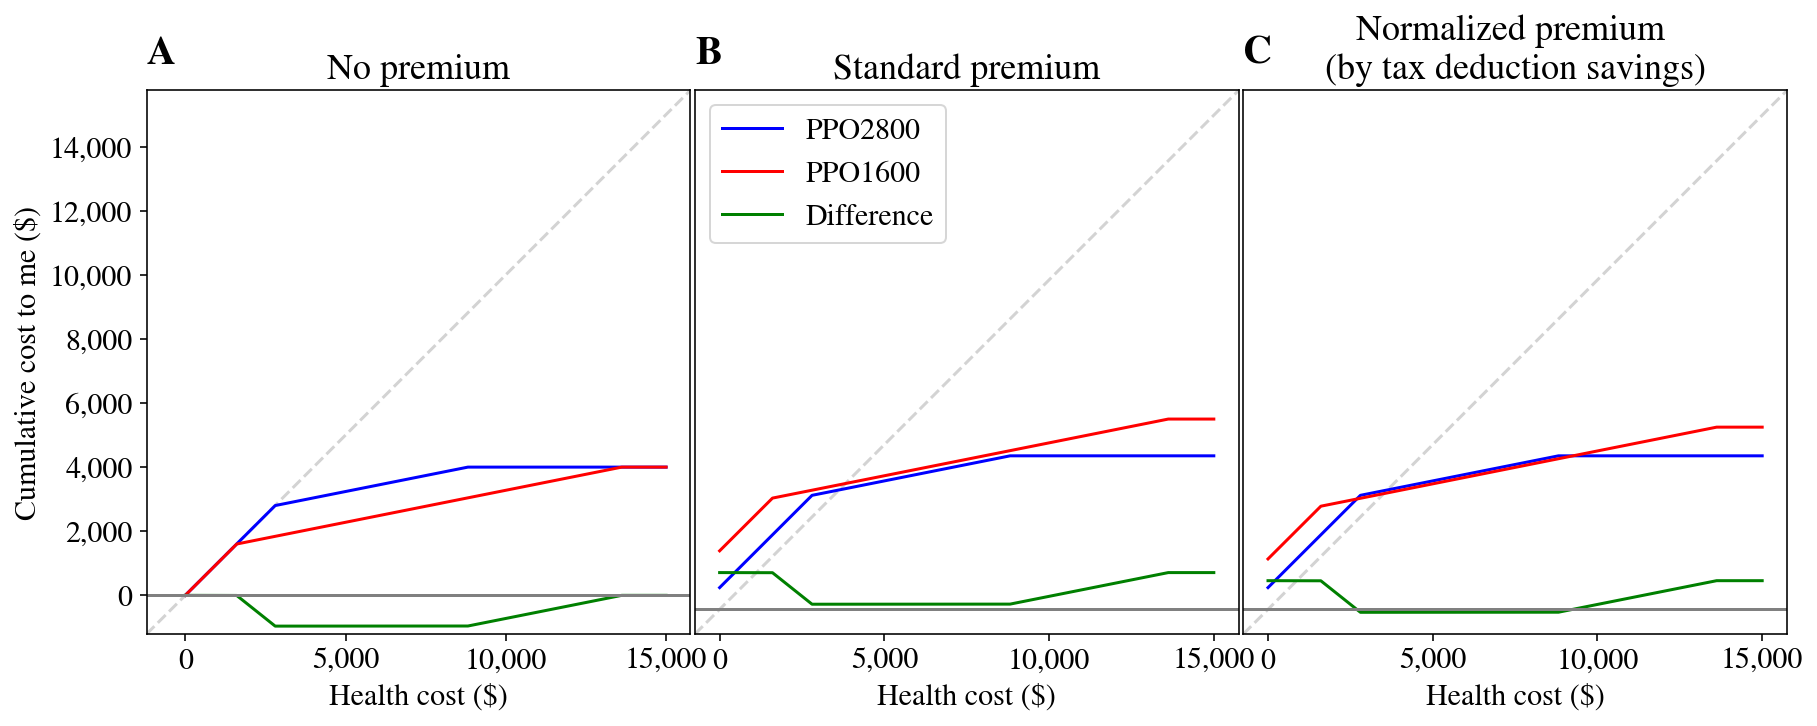

In [18]:
fig, axs = plt.subplots(figsize=(15,5), ncols=3)
fig.subplots_adjust(hspace=0, wspace=-0.05)
x = np.arange(0, 15_000)

for label, data in plans.items():
  norm = data["norm"]
  p = data["p"]
  d = data["d"]
  oopm = data["oopm"]
  norm = data["norm"]
  color = data["color"]

  y0 = np.array([insurance_cost(i, 0, d, oopm) for i in x])
  # health_cost_at_oopm = x[np.where(y == oopm + p)[0][0]]
  axs[0].plot(x, y0, label=label, color=color)

  y1 = np.array([insurance_cost(i, p, d, oopm) for i in x])
  # health_cost_at_oopm = x[np.where(y == oopm + p)[0][0]]
  axs[1].plot(x, y1, label=label, color=color)

  y2 = np.array([insurance_cost(i, p-norm, d, oopm) for i in x])
  # health_cost_at_oopm = x[np.where(y == oopm + p)[0][0]]
  axs[2].plot(x, y2, label=label, color=color)
  
  # ax.axhline(y=d+p, color=color, linestyle="--") # premium + deductible
  # ax.axvline(x=health_cost_at_oopm, color=color, linestyle="--") # health cost at oopm

  if label == "PPO2800":
    ppo2800_0 = y0
    ppo2800_1 = y1
    ppo2800_2 = y2
  elif label == "PPO1600":
    ppo1600_0 = y0
    ppo1600_1 = y1
    ppo1600_2 = y2

# # Difference
axs[0].plot(x, ppo1600_0-ppo2800_0, color="green", label="Difference") # Diff in price
axs[1].plot(x, ppo1600_1-ppo2800_1, color="green", label="Difference") # Diff in price
axs[2].plot(x, ppo1600_2-ppo2800_2, color="green", label="Difference") # Diff in price

for ax in axs:
  ax.axhline(y=0, color="grey")
  yex(ax)
  ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
  ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


# plot settings
axs[0].set(**{
    "xlabel": "Health cost ($)",
    "ylabel": "Cumulative cost to me ($)",
    "title": "No premium"
})
axs[1].set(**{
    "xlabel": "Health cost ($)",
    "yticks": [],
    "yticklabels": [],
    "title": "Standard premium"
})
axs[2].set(**{
    "xlabel": "Health cost ($)",
    "yticks": [],
    "yticklabels": [],
    "title": "Normalized premium \n(by tax deduction savings)"
})

# axs[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[1].legend()

for n, ax in enumerate(axs.flat):

    ax.imshow(np.random.randn(10,10), interpolation='none')    
    ax.text(0, 1.05, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')

fig.savefig("healthcare.png", dpi=300)
fig.show()

In [9]:
print(f"{min(ppo1600_0-ppo2800_0):,.2f}", f"{max(ppo1600_0-ppo2800_0):,.2f}")
print(f"{min(ppo1600_1-ppo2800_1):,.2f}", f"{max(ppo1600_1-ppo2800_1):,.2f}")
print(f"{min(ppo1600_2-ppo2800_2):,.2f}", f"{max(ppo1600_2-ppo2800_2):,.2f}")

-960.00 0.00
156.00 1,116.00
-89.52 870.48


In [10]:
x[np.where(ppo1600_2-ppo2800_2 < 0)[0][0]]

2689

In [11]:
x[np.where(ppo1600_2-ppo2800_2 < 0)[0][-1]]

9247

In [12]:
# how much are you saving in taxes with a higher premium?
tax(income, 666) - tax(income, 1776)

244.20000000000073

# Income assesment

In [32]:
tax_brackets

{(0, 10275): 0.1,
 (10276, 41775): 0.12,
 (41776, 89075): 0.22,
 (89076, 170050): 0.24,
 (170051, 215950): 0.32,
 (215951, 539900): 0.35,
 (539901, 9999999): 0.37}

In [51]:
lst = []
for (mn, mx), v in tax_brackets.items():
  lst.append(np.linspace(mn, mx, 10).tolist())
incomes = np.array(lst).flatten()

In [52]:
incomes.shape

(70,)

In [53]:
x = np.arange(0, 15000)

diff = np.zeros((incomes.shape[0], x.shape[0]))
costs = np.zeros((2, incomes.shape[0], x.shape[0]))
for idx, inc in enumerate(incomes):
  norm = tax(inc, plans["PPO2800"]["p"]) - tax(inc, plans["PPO1600"]["p"])
  for jdx, i in enumerate(x):

    c1 = insurance_cost(i, plans["PPO1600"]["p"]-norm, plans["PPO1600"]["d"], plans["PPO1600"]["oopm"])
    c2 = insurance_cost(i, plans["PPO2800"]["p"]     , plans["PPO2800"]["d"], plans["PPO2800"]["oopm"])

    diff[idx][jdx]= c1-c2
    costs[0][idx][jdx] = c1
    costs[1][idx][jdx] = c2

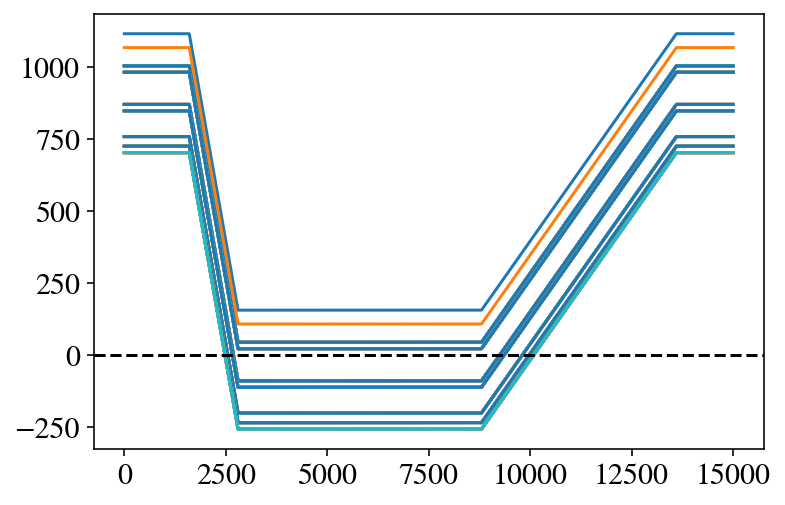

In [54]:
fig, ax = plt.subplots()

for inc, d in zip(incomes, diff):
  ax.plot(d, label=inc)

ax.axhline(0, color="k", linestyle="--")
#ax.legend()
fig.show()

In [55]:
diff.mean()

272.58790476190785

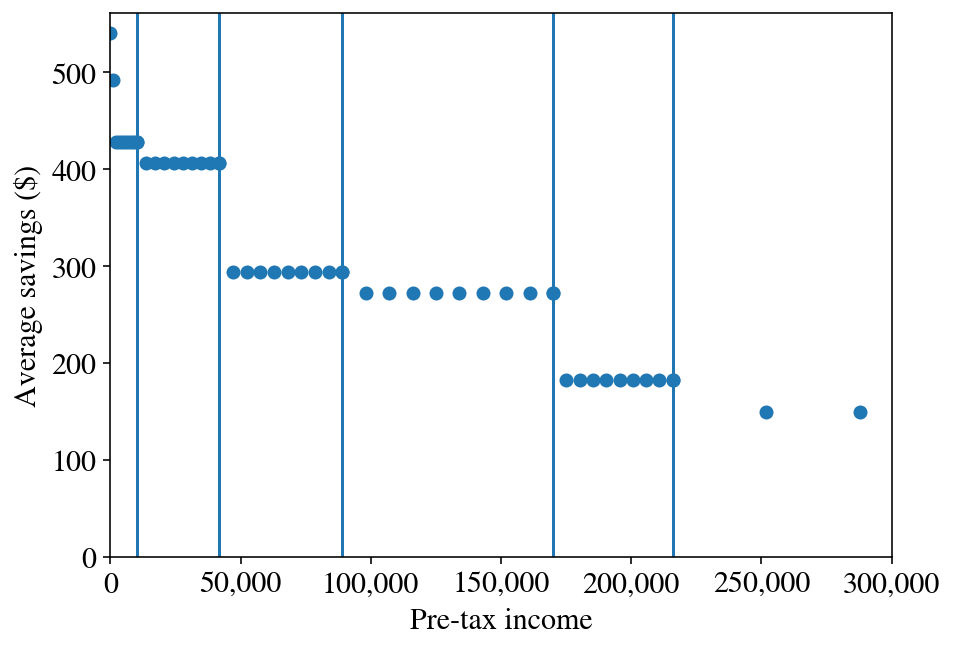

In [56]:
fig, ax = plt.subplots(figsize=(7, 5))
x = incomes
y = diff.mean(1)

ax.scatter(x,y, label="Average savings")

ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

for l,h in tax_brackets.keys():
  ax.axvline(h)

ax.set(**{
    "xlabel": "Pre-tax income",
    "ylabel": "Average savings ($)",
    "ylim": 0,
    "xlim": (0, 300_000),
})
fig.show()

In [64]:
# avg min savings
(costs[0] -costs[1]).min(1).reshape(-1,10).mean(1).reshape(-1,1)

array([[  61.90333333],
       [  24.312     ],
       [ -78.36      ],
       [-109.608     ],
       [-192.192     ],
       [-231.252     ],
       [-254.688     ]])

In [65]:
# avg max savings
(costs[0] - costs[1]).max(1).reshape(-1,10).mean(1).reshape(-1,1)

array([[1021.90333333],
       [ 984.312     ],
       [ 881.64      ],
       [ 850.392     ],
       [ 767.808     ],
       [ 728.748     ],
       [ 705.312     ]])

In [62]:
# tax brackets
list(tax_brackets.keys())

[(0, 10275),
 (10276, 41775),
 (41776, 89075),
 (89076, 170050),
 (170051, 215950),
 (215951, 539900),
 (539901, 9999999)]

In [66]:
tax_brackets

{(0, 10275): 0.1,
 (10276, 41775): 0.12,
 (41776, 89075): 0.22,
 (89076, 170050): 0.24,
 (170051, 215950): 0.32,
 (215951, 539900): 0.35,
 (539901, 9999999): 0.37}

In [ ]:
# only other place I've seen this analysis http://familycarepa.com/2018-state-health-plan/